<a href="https://colab.research.google.com/github/Demon-God-King/GoogleColab/blob/main/shelter_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting dog adoption at the Sonoma animal shelter

Which dogs at the Sonoma animal shelter tend to be adopted?  We can try to answer this question by creating a machine learning algorithm that will predict, from data available when a dot is taken in, whether the dog will be adopted.  Is it possible to accurately predict whether a dog will be adopted?  If so, are factors like age and size important? 

### Instructions:

- Please read the entire notebook carefully.
- Problems are shown in code cells below; each problem begins with #@.
- Do not make changes outside the problem cells.
- I provide output for some problem cells.  When I do so, you should try to replicate my output.
- Run your code from top to bottom before submitting.
- Do not modify the file name.

The usual course honor policy applies.  Do not share code with others, do not look at others' code, and do not look for solutions to the problems on the web.  You are of course allowed to look on the web for how to use NumPy, Pandas, etc.

I wanted to share my thought process in creating the notebook, so put my thoughts in italics.  My comments in a professional report would be written in a more formal style.

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

import matplotlib.pyplot as plt
import seaborn as sns

#### Plotting style parameters

In [ ]:
# switch to seaborn default stylistic parameters
sns.set()
sns.set_context('notebook') 
sns.set_style('whitegrid')

In [ ]:
# code in this cell from: 
# https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

"""
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to display/hide the code."></form>''')
"""

'\nHTML(\'\'\'<script>\ncode_show=true; \nfunction code_toggle() {\n if (code_show){\n $(\'div.input\').hide();\n } else {\n $(\'div.input\').show();\n }\n code_show = !code_show\n} \n$( document ).ready(code_toggle);\n</script>\n<form action="javascript:code_toggle()"><input type="submit" value="Click here to display/hide the code."></form>\'\'\')\n'

#### Function definitions

In [ ]:
def plot_learning_curve(train_sizes, train_scores, test_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, label='train')
    plt.plot(train_sizes, test_scores_mean, label='test')
    plt.xlabel('training set size')
    plt.ylabel('accuracy')
    plt.title('Learning curve')
    plt.legend();

In [ ]:
def print_conf_mtx(y_true, y_pred, classes=None):
    """ Print a confusion matrix (two classes only). """
    
    if not classes:
        classes = ['neg', 'pos']
        
    # formatting
    max_class_len = max([len(s) for s in classes])
    m = max(max_class_len, len('predicted')//2 + 1)
    n = max(len('actual')+1, max_class_len)
    left       = '{:<10s}'.replace('10',str(n))
    right      = '{:>10s}'.replace('10',str(m))
    big_center = '{:^20s}'.replace('20',str(m*2))
    
    cm = confusion_matrix(y_true, y_pred)
    print((left+big_center).format('', 'predicted'))
    print((left+right+right).format('actual', classes[0], classes[1]))
    print((left+right+right).format(classes[0], str(cm[0,0]), str(cm[0,1])))
    print((left+right+right).format(classes[1], str(cm[1,0]), str(cm[1,1])))

### Read the data

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/grbruns/cst383/master/sonoma-shelter-12-2022.csv")

In [ ]:
df = df[df['Type'] == 'DOG']
df.drop('Type', axis=1, inplace=True)

In [ ]:
df['Intake Date'] = pd.to_datetime(df['Intake Date'])
df['Date Of Birth'] = pd.to_datetime(df['Date Of Birth'])

df.set_index('Intake Date', inplace=True)
df.sort_index(inplace=True)

## Preliminary exploration

_As a first step, I want to get an overview of the data and an idea of the kind of preprocessing I might need to do._

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12454 entries, 2013-08-22 to 2021-11-29
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Name                  11237 non-null  object        
 1   Breed                 12454 non-null  object        
 2   Color                 12454 non-null  object        
 3   Sex                   12454 non-null  object        
 4   Size                  12423 non-null  object        
 5   Date Of Birth         10377 non-null  datetime64[ns]
 6   Impound Number        12454 non-null  object        
 7   Kennel Number         12451 non-null  object        
 8   Animal ID             12454 non-null  object        
 9   Outcome Date          12379 non-null  object        
 10  Days in Shelter       12454 non-null  int64         
 11  Intake Type           12454 non-null  object        
 12  Intake Subtype        12454 non-null  object        
 13 

_There is not a lot of missing data, but the date of birth is missing in more than 15% of the rows.  This makes sense, since some animals are probably strays with no identifying information._

_Looking at the number of unique values for each variable can help in understanding its type._

In [ ]:
df.nunique()

Name                     4259
Breed                     803
Color                     197
Sex                         5
Size                        6
Date Of Birth            4301
Impound Number          12454
Kennel Number             146
Animal ID               10613
Outcome Date             2250
Days in Shelter           240
Intake Type                 7
Intake Subtype             28
Outcome Type                9
Outcome Subtype           192
Intake Condition            5
Outcome Condition           6
Intake Jurisdiction        13
Outcome Jurisdiction       12
Outcome Zip Code          568
Location                  568
Count                       2
dtype: int64

_There are many breeds, colors, and quite a few intake subtypes._

_Which dog breeds are common at the shelter?_

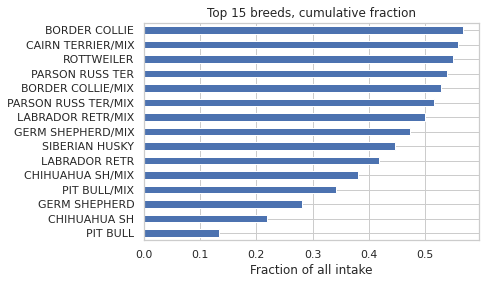

In [ ]:
df['Breed'].value_counts(normalize=True).cumsum()[:15].plot.barh().set_title('Top 15 breeds, cumulative fraction')
plt.xlabel('Fraction of all intake');

_The cumulative plot let's me immediately see that the top 15 breeds cover almost 60% of the dogs.  The breed variable is complicated by the mixes.  If you lump pit bull and pit bull mix together, they account for about 20% of the dogs at the shelter._

_What is the distribution of intake type and outcome type?_

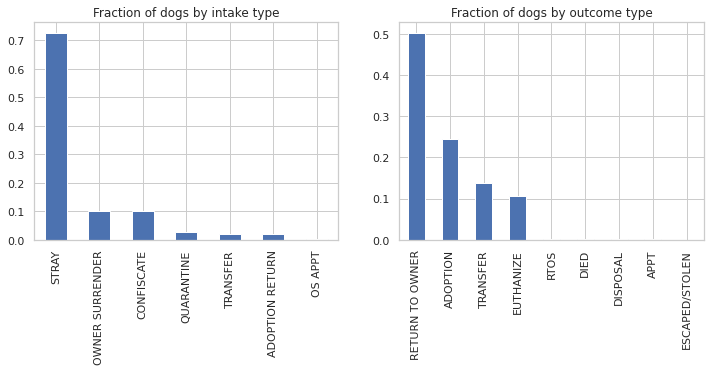

In [ ]:
fig,ax = plt.subplots(1, 2, figsize=(12, 4))
df['Intake Type'].value_counts(normalize=True).plot.bar(ax=ax[0]).set_title('Fraction of dogs by intake type')
df['Outcome Type'].value_counts(normalize=True).plot.bar(ax=ax[1]).set_title('Fraction of dogs by outcome type');

_By far, most dogs enter the shelter as strays.  Interestingly, about half the dogs leave by being returned to owner.  Less than a quarter of the dogs that enter are adopted.  Sadly, about 1 in 10 dogs that enter the shelter are euthanized._

_Many dogs are returned to their owner.  For the purpose of understanding adoption, I will not look at dogs that were returned to their owner.  Instead, I will try to predict which will be adopted, as opposed to transferred or euthanized.  The other outcome types are very rare._

_It's surprising that a large proportion of the dogs taken to the shelter are pit bulls or pit bull mixes._

_What is the distribution of dog sizes?_

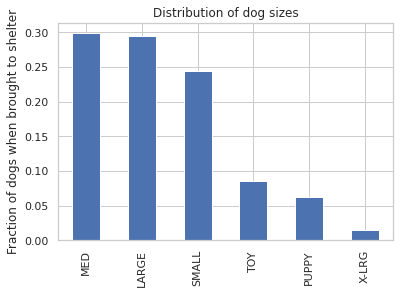

In [ ]:
df['Size'].value_counts(normalize=True).plot.bar()
plt.title('Distribution of dog sizes')
plt.ylabel('Fraction of dogs when brought to shelter');

_'PUPPY' is a dog size?  That seems very strange.  It's true that puppies tend to be small, but some puppies are much larger than others.  Maybe 'PUPPY' is used because a puppy's size changes quickly._

## Data preprocessing

Summary of the preprocessing:
- Drop variables related to outcome, except for Outcome Type.
- Drop variables that are certain to not be used.
- Drop data related to outcome types besides adoption, transfer, and euthanization.
- Derive new columns 'Age' and 'Unknown DOB'.
- Drop any remaining rows with NA values.

The details of these preprocessing steps were covered in a previous assignment.

In [ ]:
df.drop(['Days in Shelter', 'Outcome Date', 'Outcome Subtype', 'Outcome Condition', 'Outcome Jurisdiction', 'Outcome Zip Code', 'Location'], 
        axis=1, inplace=True)
df.drop(['Name', 'Impound Number', 'Kennel Number', 'Animal ID', 'Intake Jurisdiction', 'Count'], 
        axis=1, inplace=True)
df.drop(['Color'], axis=1, inplace=True)
df = df[df['Outcome Type'].isin(['ADOPTION', 'TRANSFER', 'EUTHANIZE'])]
df = df[df['Intake Type'] != "OS APPT"]

# The new Age variable is in units of years
df['Age'] = (df.index - df['Date Of Birth'])/np.timedelta64(1, 'Y')
df['Unknown DOB'] = (df['Date Of Birth'].isna()).astype(int)
df.drop('Date Of Birth', axis=1, inplace=True)
df = df[df['Age'] >= 0.0 ]
df['Age'].fillna(df['Age'].median(), inplace=True)
df.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


_Now that we have an age variable, we can do a sanity check that puppies are young._

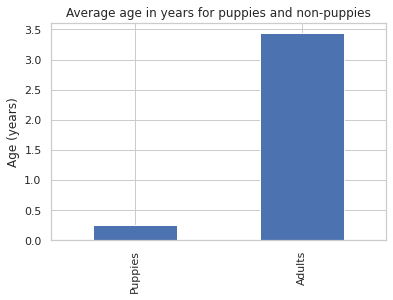

In [ ]:
#@ 1 Create a plot showing the average age in years for puppies and non-puppies.
# Hint: we want to group by whether the value of variable size is 'PUPPY'.

# YOUR CODE HERE
# df.groupby('Age').mean().plot.bar()
# plt.xticks(np.arange(2), ['Puppies', 'Adults']) 
# locs, labels = plt.xticks()  
fig, ax = plt.subplots()
df.groupby(df['Size'] == 'PUPPY')['Age'].mean().sort_index(ascending=False).plot.bar(rot=90)
labels = ['Puppies', 'Adults']
plt.title('Average age in years for puppies and non-puppies')
plt.ylabel('Age (years)')
plt.xlabel('')
ax.set_xticklabels(labels);

_The average age of puppies is about 3 months, as expected._

_It's a good idea to get a data summary after preprocessing._

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5261 entries, 2013-08-22 to 2021-11-10
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Breed             5261 non-null   object 
 1   Sex               5261 non-null   object 
 2   Size              5261 non-null   object 
 3   Intake Type       5261 non-null   object 
 4   Intake Subtype    5261 non-null   object 
 5   Outcome Type      5261 non-null   object 
 6   Intake Condition  5261 non-null   object 
 7   Age               5261 non-null   float64
 8   Unknown DOB       5261 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 411.0+ KB


#### Additional preprocessing for machine learning

_All the variables except for age are categorical, and we need to encode categorical variables according to their type._

_The intake subtype and breed variables are a problem because they have many possible values.  Using dummy variables will cause many new variables to be created._

_Many of the intake subtype values rarely appear, so we will keep the top five values only, and replace all other values with 'OTHER'._

In [ ]:
top_subtypes = df['Intake Subtype'].value_counts().index[:5]
df.loc[~df['Intake Subtype'].isin(top_subtypes), 'Intake Subtype'] = 'OTHER'

_There are many breeds.  Also, some overlap.  We will first combine categories, then retain only the most popular breeds._

In [ ]:
replace_dict = {
    'PIT BULL/MIX': 'PIT BULL',
    'CHIHUAHUA SH/MIX': 'CHIHUAHUA SH',
    'GERM SHEPHERD/MIX': 'GERM SHEPHERD',
    'LABRADOR RETR/MIX': 'LABRADOR RETR'
}

df['Breed'].replace(replace_dict, inplace=True)
top_breeds = df['Breed'].value_counts().index[:4]
df.loc[~df['Breed'].isin(top_breeds), 'Breed'] = 'OTHER'

_Create the target variable, plus another variable for euthanization.  I may want to look into euthanization._

In [ ]:
df['Adopted'] = (df['Outcome Type'] == 'ADOPTION').astype(int)
df['Euthanized'] = (df['Outcome Type'] == 'EUTHANIZATION').astype(int)
df.drop('Outcome Type', axis=1, inplace=True)

_Size is an ordinal variable, so ordinal encoding makes sense.  However, we've seen that PUPPY is a possible value of the size variable._

_The approach I use is to first create a new 'Puppy' variable, and then to use 'SMALL' as the size of puppies.  This approach may not be perfect, but I can try alternative later if it seems worthwhile._

In [ ]:
df['Puppy'] = (df['Size'] == 'PUPPY').astype(int)

replace_dict = {
    'TOY': 0,
    'PUPPY': 0,
    'SMALL': 1,
    'MED': 2,
    'LARGE': 3,
    'X-LRG': 4
}

df['Size'].replace(replace_dict, inplace=True)

_Encode the categorical variables._

In [ ]:
df = pd.get_dummies(df, drop_first=True)

_Again, it is useful to summarize the data after a lot of processing.  We expect all variables to be numeric now._

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5261 entries, 2013-08-22 to 2021-11-10
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Size                                   5261 non-null   int64  
 1   Age                                    5261 non-null   float64
 2   Unknown DOB                            5261 non-null   int64  
 3   Adopted                                5261 non-null   int64  
 4   Euthanized                             5261 non-null   int64  
 5   Puppy                                  5261 non-null   int64  
 6   Breed_GERM SHEPHERD                    5261 non-null   uint8  
 7   Breed_LABRADOR RETR                    5261 non-null   uint8  
 8   Breed_OTHER                            5261 non-null   uint8  
 9   Breed_PIT BULL                         5261 non-null   uint8  
 10  Sex_Male                               5261 non-null  

#### Convert Pandas data to NumPy

In [ ]:
target = 'Adopted'
predictors = df.columns[~df.columns.isin(['Adopted', 'Euthanized'])]

In [ ]:
X = df[predictors].values
y = df[target].values

#### Train/test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
print('The training set has {} rows, with {} predictor variables.'.format(X_train.shape[0], X_train.shape[1]))

The training set has 3682 rows, with 26 predictor variables.


#### Scale the data
 
_I would like to scale only the quantitative variables, not the dummy variables.  I will use a method that is convenient, but hasn't been explained in class yet._

_The ColumnTransormer class of Scikit-Learn allows for columns of a 2D array to be treated separately.  In this case I want to scale only the quantitative variables, which are columns 0 and 1._

In [ ]:
quant_features = [0,1]
xform = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), quant_features)
    ],
    remainder='passthrough'  # do nothing with other columns
)

_The ColumnTransformer object is called xform.  Now I can use it to perform the scaling._

In [ ]:
X_train = xform.fit_transform(X_train)
X_test  = xform.transform(X_test)

_As a sanity check, I'll ensure that the shape of the training data hasn't changed._

In [ ]:
print(X_train.shape)

(3682, 26)


## Machine learning

### Baseline accuracy

_Before doing any machine learning, it's wise to get a baseline accuracy that we can compare our later results to.  For classification problems, the baseline accuracy is the accuracy you'd get by always predicting the most common target value.  This is sometimes called the "zero rule"._

_First we compute the most common target value.  Note the use of return_counts=True in np.unique().  This make the output of np.unique() similar to value_counts() of Pandas._

In [ ]:
vals, counts = np.unique(y_train, return_counts=True)
target_mode = vals[counts.argmax()]
print('Most common target value: {}'.format(target_mode))

Most common target value: 1


_It is more common for dogs to be adopted than not adoped.  Now we compute the training set accuracy._

In [ ]:
#@ 2 Compute and print the baseline accuracy.
# Hint: you will need target_mode.
# Hint: use the training data, not the test data.

# YOUR CODE HERE
print("Baseline Accuracy: ",(y_train == np.median(y_train)).mean().round(3))

Baseline Accuracy:  0.567


_We can achieve about 0.57 accuracy by always predicting that a dog will be adopted._

_We are finally ready to start machine learning._

_Following the process outlined in class (in the lecture on overfitting and learning curves), we want to start with a simple yet flexible classifier, and try to reach a situation of overfitting.  Then, we will reduce overfitting as needed._

_We have seen two classifiers: KNN classification and logistic regression.  We'll start with KNN classification._

### KNN classifier

_I'm saving the test data for a final evaluation of test accuracy.  Therefore, I'll evaluate the performance of the classifier using cross validation, not with test data._

_I'm using k=3 in KNN because I expect I will achieve overfitting with a small value of n._

In [ ]:
#@ 3 Create a KNN classifier, assign to clf
# Hint: this is easy; just be sure to use the correct Scikit-Learn estimator class,
# and don't forget to use 3 as number of nearest neighbors.

# YOUR CODE HERE
clf = KNeighborsClassifier(n_neighbors=3)


In [ ]:
#@ 4 Compute and print the cross validation accuracy
# Use 10-fold cross validation.
# Hint: Use a Scikit-learn function to compute the cross-validation score.
# Hint: We use training data to compute cross-validation scores.

# YOUR CODE HERE
clf.fit(X_train, y_train)
print("Cross-validation accuracy: ",cross_val_score(clf, X_train, y_train, cv=10).mean().round(3))

Cross-validation accuracy:  0.763


_This value is about 35% better than the baseline.  However, it could be that we are overfitting.  Let's create a learning curve._

_The data for the learning curve takes some time to generate, because for each subset of the training data, we are performing cross validation.  I'm using cv=5 so that learning_curve() does not take too long to run._

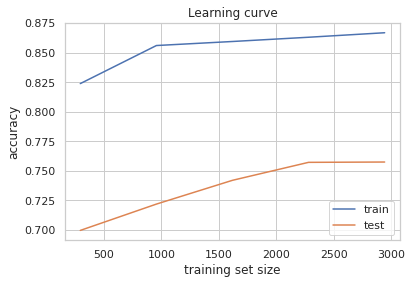

In [ ]:
#@ 5 Produce a learning curve plot using learning_curve() and plot_learning_curve() functions.
# The learning_curve() function is from Scikit-Learn.  The plot_learning_curve() function is
# defined near the top of this file.
# Use 5-fold cross-validation in creating the learning curve().

# YOUR CODE HERE
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=5,scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label='train')
plt.plot(train_sizes, test_scores_mean, label='test')
plt.xlabel('training set size')
plt.ylabel('accuracy')
plt.title('Learning curve')
plt.legend();

_As I hoped, we are definitely overfitting.  The next step is to reduce overfitting.  With KNN classification, one way to do this is by increasing k.  I could create a learning curve for different values of k.  However, it will be faster to perform a simple grid search.  Anyway, the ultimate goal is a high test accuracy.  Avoiding overfitting is not a goal in itself, but simply a way to try to achieve high test accuracy._

_I'll try k values of 7, 9, 11, ..., 21._

In [ ]:
#@ 6 compute cross validation accuracy for KNN for k values of 7,9,11,...,21
# Store the result in list cv_accuracy.  There will be one value in cv_accuracy
# for each value in ks.
# Use Scikit-Learn's cross_val_score() to compute cross-validation accuracy.
# Use 5-fold cross validation.

cv_accuracy = []
ks = range(7, 22, 2)
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    # YOUR CODE HERE
    accs = cross_val_score(knn, X_train, y_train,scoring="accuracy", cv=5)
    cv_accuracy.append(accs.mean())

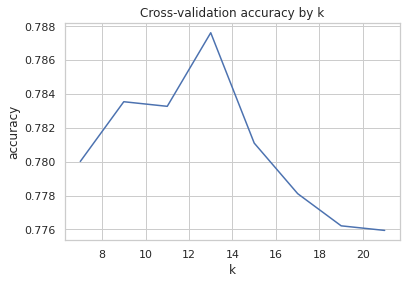

In [ ]:
plt.plot(ks, cv_accuracy)
plt.title('Cross-validation accuracy by k')
plt.xlabel('k')
plt.ylabel('accuracy');

_This plot suggest a value of k=13 is a good choice.  However, looking at the y axis, we see that values between about 9 and 15 give very similar accuracies._

_I'll create a new learning curve with this k value.  I expect overfitting to be reduced._

In [ ]:
clf = KNeighborsClassifier(n_neighbors=13)

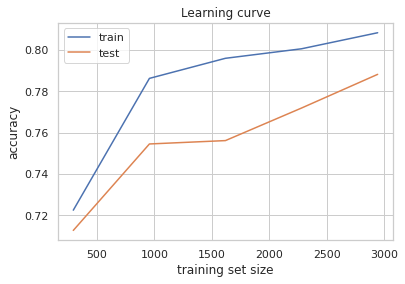

In [ ]:
#@ 7 produce a learning curve
# Hint: this is similar to an earlier problem.
# Make sure to use the KNN classifier just defined.
# Use 5-fold cross-validation in creating the learning curve().

# YOUR CODE HERE
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=5,scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label='train')
plt.plot(train_sizes, test_scores_mean, label='test')
plt.xlabel('training set size')
plt.ylabel('accuracy')
plt.title('Learning curve')
plt.legend();

_Overfitting has been reduced.  It looks like there is still a lot of overfitting, but if you look at the y axis, you can see that the range is much smaller than in the last learning curve.  The difference between training and test accuracy with a training set size of 3,000 is now only about 0.02.  Before it was 0.10 -- about 5 times larger._

_There are a couple of issues that might be affecting the accuracy I'm geting with the KNN classifier:_
- _KNN works best with continuous data, and most of the variables in this data set are categorical._
- _I haven't tried Manhattan distance or other distance functions._

### Logistic regression

_I want to repeat the process I used with KNN regression.  It's much faster to train logistic regression than KNN regression with a data set of this size._

In [ ]:
#@ 8 Compute and print the cross validation accuracy for a logistic regression classifier.
# Hint: don't forget that we use training data when compute cross validation accuracy.

# YOUR CODE HERE
clf = LogisticRegression()
print("Cross-validation accuracy: ",cross_val_score(clf, X_train, y_train, cv=10).mean().round(3))

Cross-validation accuracy:  0.822


_Logistic regression is outperforming KNN regression right away._

_To get an idea of which variables are most significant, we can look at the magnitude of their coefficients.  The coefficient magnitudes can only be compared directly if the data has been scaled, which it has._

In [ ]:
#@ 9 Create a logistic regression classifier (call it 'clf') and train it using the training data.
# Hint: this is simple because logistic regression has no hyperparameters.

# YOUR CODE HERE
clf=LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

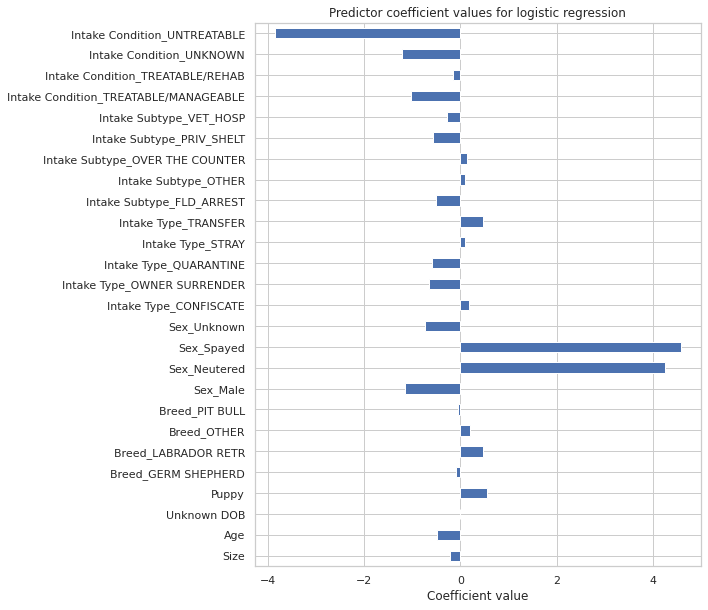

In [ ]:
#@ 10 In a horizontal bar plot, plot the coefficient associated with each predictor variable.
# For title, use "Predictor coefficient values for logistic regression".
# The predictor names should be listed on the y axis.  No y axis label is needed.
# For x axis label, use "coefficient value".
# Hint: use plt.figure(figsize=(<width>, <height>)) to make sure your plot is large enough.
# (You must supply values for parameters <width> and <height>.)

# YOUR CODE HERE
# list = []
# for i in range(len(predictors)):
#   list = clf.coef_[i]


#list.plot.barh()

#[clf.intercept_,clf.coef_[1],clf.coef[2]].plot.barh() 

# len(predictors)
# predictors


# y.shape

# X = np.random.rand(10, 2)
# y = np.random.choice([0,1], 10)
# regr = LogisticRegression()
# regr.fit(X, y)
# x=np.sort(clf.coef_[0])
# print(regr.coef_.shape)
# sns.barplot(x=x,y=predictors)
plt.figure(figsize=(8,10))
# plt.barh(predictors,clf.coef_[0])
pred =pd.Series(clf.coef_[0])
pred.index = predictors
pred.plot.barh();
plt.title('Predictor coefficient values for logistic regression')  
plt.xlabel('Coefficient value');


In [ ]:
#@ 11 Comment on the plot you have just created in the markdown cell immediately below.
# Hint: What did you learn from the plot?



According to the graph, the adoption of dogs in shelters whose conditions are untreatable are highly correlated with the adoption of dogs. According to the graph, there are a greater number of dogs whose condition is untreatable and unknown; probably all of them are strays and are less likely to be adopted. It was also interesting to learn that Pitbulls were the most commonly confiscated and stray dogs. 

What is the learning curve like for our logistic regression model?_

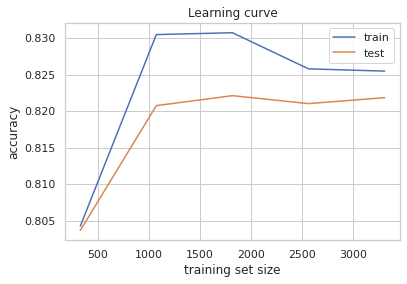

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=10, scoring='accuracy')
plot_learning_curve(train_sizes, train_scores, test_scores)

_It is is not a strongly high bias or high variance situation, but I would lean towards interpreting this as high bias situation because the test and training accuracy differ by only about 0.005 before all the training data is used._

_One idea would be to add more features using Polynomial features.  However, if we use only degree 2, and interaction features only, we will end up with more than 300 features.  This is a very large number of features for a training data set with only about 3500 rows._

#### Confusion matrix

_I'll produce a confusion matrix now to see where the predictions are wrong._

In [ ]:
y_pred = cross_val_predict(clf, X_train, y_train, cv=5)

In [ ]:
#@ 12 Plot the confusion matrix.
# Use the print_conf_mtx() method provided near the top of the file.

# YOUR CODE HERE
print_conf_mtx(y_train, y_pred,classes=['Not adopted','Adopted'])

                 predicted       
actual     Not adopted    Adopted
Not adopted       1064        529
Adopted            130       1959


The confusion matrix shows that most of the errors are for the case where we predict a dog is adopted but actually it is not adopted._

### Compute test accuracy

_Using cross-validation I've found that logistic regression seems to outperform KNN regression for this classification problem._

_As a final step, I'll train a logistic regression classifier on the full training data set and then compute the test accuracy._

In [ ]:
#@ 13 Compute the final test accuracy and store it to variable 'score'.

# YOUR CODE HERE
score=clf.score(X_test,y_test)

In [ ]:
print('Test accuracy: {:.3f}'.format(score))

Test accuracy: 0.820


### Conclusion

In [ ]:
#@ 14 In the cell below, write your own conclusions

Pitbulls and Pitbull mix dogs make up 20% of all dogs.And the dogs that mostly enter the shelter are strays. There is a 57 percent chance that a dog will be adopted. Also, about half the dogs are returned to their owners. And about 1 in 10 dogs that enter the shelter are euthanized. Also, smaller dogs are mostly adopted.